### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns

from openaq_anomaly_prediction.config import Configuration as config
from openaq_anomaly_prediction.utils.logging import logger, ProgressLogger
from openaq_anomaly_prediction.load.openaq import client as openaq, AreaDownloader

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)

01:08:26  SUCCESS |  OPENAQ: APIKEY="0942d3c2c4c9503a675043c169119ff1a9c0e8160da51bbe18caa6f470ffafc8"


### Load dataset

#### LOAD variables (Parquet file)

In [2]:
df_int_file = "new_delhi_2024_measurements.int.parquet"
df_int_path = os.path.join(config.DATA_CSV_PATH, df_int_file)

01:09:22  SUCCESS |  OPENAQ: APIKEY="0942d3c2c4c9503a675043c169119ff1a9c0e8160da51bbe18caa6f470ffafc8"


In [3]:
schema = pq.read_schema(df_int_path)
print(schema)
# print(schema.names)

location_id: int64
sensor_id: int64
name: string
value: double
parameter.id: int64
parameter.name: string
parameter.units: string
parameter.displayName: string
period.datetimeFrom.local: timestamp[ns, tz=+05:30]
period.datetimeTo.local: timestamp[ns, tz=+05:30]
period.datetimeFrom.utc: timestamp[ns, tz=UTC]
period.datetimeTo.utc: timestamp[ns, tz=UTC]
location.datetimeFirst.utc: timestamp[ns, tz=UTC]
location.datetimeLast.utc: timestamp[ns, tz=UTC]
coordinates.latitude: double
coordinates.longitude: double
location_name: string
isMobile: bool
isMonitor: bool
country.id: int64
country.code: string
country.name: string
owner.id: int64
owner.name: string
provider.id: int64
provider.name: string
coverage.expectedCount: int64
coverage.observedCount: int64
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 3874


In [4]:
metadata = pq.read_metadata(df_int_path)
print(metadata)
print()

if metadata.num_row_groups > 0:
    for i in range(metadata.num_row_groups):
        print(f"Rows in row group {i}: {metadata.row_group(i).num_rows}")

  created_by: parquet-cpp-arrow version 22.0.0
  num_columns: 28
  num_rows: 42107
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 15776

Rows in row group 0: 42107


In [5]:
df = pd.read_parquet(df_int_path)

#### FILTER the rows

In [8]:
# FILTER the raw parquet file to only include the desired rows
import pyarrow.dataset as ds

# Assuming 'date_column' is a date or timestamp column
start_date = pd.Timestamp("2024-01-01")
end_date = pd.Timestamp("2024-12-31")

# Match the exact type of the period.datetimeTo.local column
target_type = pa.timestamp("ns", tz="+05:30")
start_date_localized = start_date.tz_localize("+05:30")
end_date_localized = end_date.tz_localize("+05:30")

# Convert pandas Timestamps to PyArrow Scalars with the target type
start_scalar = pa.scalar(start_date_localized, type=target_type)
end_scalar = pa.scalar(end_date_localized, type=target_type)

date_filter = (ds.field("period.datetimeTo.local") >= start_scalar) & (
    ds.field("period.datetimeTo.local") <= end_scalar
)

filtered_table = pq.read_table(
    df_int_path,
    filters=date_filter,
    # Optional: only load the columns you actually need
    columns=[
        "location_id",
        "sensor_id",
        "name",
        "value",
        "parameter.id",
        "parameter.name",
        "parameter.units",
        "parameter.displayName",
        "period.datetimeFrom.local",
        "period.datetimeTo.local",
        "period.datetimeFrom.utc",
        "period.datetimeTo.utc",
        # "location.datetimeFirst.utc",
        # "location.datetimeLast.utc",
        "coordinates.latitude",
        "coordinates.longitude",
        # "location_name",
        "isMobile",
        "isMonitor",
        # "country.id",
        # "country.code",
        # "country.name",
        # "owner.id",
        "owner.name",
        # "provider.id",
        "provider.name",
        # "coverage.expectedCount",
        # "coverage.observedCount",
    ],
)

# Convert the filtered result to a pandas DataFrame
filtered_df = filtered_table.to_pandas()
filtered_df.shape

(41876, 18)

In [9]:
filtered_df.head(5)

,location_id,sensor_id,name,value,parameter.id,parameter.name,parameter.units,parameter.displayName,period.datetimeFrom.local,period.datetimeTo.local,period.datetimeFrom.utc,period.datetimeTo.utc,coordinates.latitude,coordinates.longitude,isMobile,isMonitor,owner.name,provider.name
0,8118,23534,pm25 µg/m³,199.0,2,pm25,µg/m³,PM2.5,2024-01-01 05:00:00+05:30,2024-01-01 06:00:00+05:30,2023-12-31 23:30:00+00:00,2024-01-01 00:30:00+00:00,28.63576,77.22445,False,True,Unknown Governmental Organization,AirNow
1,8118,23534,pm25 µg/m³,197.0,2,pm25,µg/m³,PM2.5,2024-01-01 06:00:00+05:30,2024-01-01 07:00:00+05:30,2024-01-01 00:30:00+00:00,2024-01-01 01:30:00+00:00,28.63576,77.22445,False,True,Unknown Governmental Organization,AirNow
2,8118,23534,pm25 µg/m³,194.0,2,pm25,µg/m³,PM2.5,2024-01-01 07:00:00+05:30,2024-01-01 08:00:00+05:30,2024-01-01 01:30:00+00:00,2024-01-01 02:30:00+00:00,28.63576,77.22445,False,True,Unknown Governmental Organization,AirNow
3,8118,23534,pm25 µg/m³,179.0,2,pm25,µg/m³,PM2.5,2024-01-01 08:00:00+05:30,2024-01-01 09:00:00+05:30,2024-01-01 02:30:00+00:00,2024-01-01 03:30:00+00:00,28.63576,77.22445,False,True,Unknown Governmental Organization,AirNow
4,8118,23534,pm25 µg/m³,180.0,2,pm25,µg/m³,PM2.5,2024-01-01 09:00:00+05:30,2024-01-01 10:00:00+05:30,2024-01-01 03:30:00+00:00,2024-01-01 04:30:00+00:00,28.63576,77.22445,False,True,Unknown Governmental Organization,AirNow


### Test pollutant coverage

In [11]:
# PREP: Identify top pollutants by number of unique locations measuring them

KEEP_TOP_N_POLLUTANTS = 12

title = "IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM"
print(f"{'='*len(title)}\n{title}\n")

print(f"Unique sensors: {filtered_df['sensor_id'].nunique()}")

print("\nNumber of unique locations measuring each parameter:")
unique_locations_groupby_name = filtered_df.groupby(["name"])["location_id"].nunique().sort_values(ascending=False)

print(unique_locations_groupby_name[:KEEP_TOP_N_POLLUTANTS])  # count() or size()
top_pollutants_name = unique_locations_groupby_name[:KEEP_TOP_N_POLLUTANTS].index.tolist()

message = f"\nTop {KEEP_TOP_N_POLLUTANTS} pollutants by number of unique locations: {top_pollutants_name}"
print(f"{message}\n{'_'*len(title)}")


IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM

Unique sensors: 8

Number of unique locations measuring each parameter:
name
pm25 µg/m³             3
pm1 µg/m³              1
pm10 µg/m³             1
relativehumidity %     1
temperature c          1
um003 particles/cm³    1
Name: location_id, dtype: int64

Top 12 pollutants by number of unique locations: ['pm25 µg/m³', 'pm1 µg/m³', 'pm10 µg/m³', 'relativehumidity %', 'temperature c', 'um003 particles/cm³']
_______________________________________________________________________


In [12]:
# TEST 1: for each location of the least common pollutant, see which pollutants are measured there

title = "POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT"
print(f"{'='*len(title)}\n{title}\n")
total_pollutants = len(top_pollutants_name)
least_common_pollutant = top_pollutants_name[-1]
least_common_pollutant_locations = filtered_df[filtered_df["name"] == least_common_pollutant]["location_id"].unique()

print(f"Checking every location ({len(least_common_pollutant_locations)}) measuring the least common pollutant ({least_common_pollutant}) to see if they also measure all top pollutants ({total_pollutants}):")
print(top_pollutants_name)
print()

full_locations = []
partial_locations = []
id_max_length = max(len(str(id)) for id in least_common_pollutant_locations)
for location in least_common_pollutant_locations:
    df_location = filtered_df[filtered_df["location_id"] == location]
    measured_parameters = df_location["name"].unique().tolist()
    overlap = set(measured_parameters).intersection(set(top_pollutants_name))
    if len(overlap) < total_pollutants:
        partial_locations.append(location)
        print(f"> Location {location:<{id_max_length}} : {len(overlap)}/{total_pollutants}")
    else:
        full_locations.append(location)

if len(partial_locations) == 0:
    print("=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS")

print()

message = f"Locations coverage for all of the top pollutants: {len(full_locations)/len(least_common_pollutant_locations):.2%} ({len(full_locations)}/{len(least_common_pollutant_locations)} locations)"
print(f"{message}\n{'_'*len(title)}")

POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT

Checking every location (1) measuring the least common pollutant (um003 particles/cm³) to see if they also measure all top pollutants (6):
['pm25 µg/m³', 'pm1 µg/m³', 'pm10 µg/m³', 'relativehumidity %', 'temperature c', 'um003 particles/cm³']

=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS

Locations coverage for all of the top pollutants: 100.00% (1/1 locations)
__________________________________________________________________________


In [38]:
# FILTER the dataframe to only include measurements from locations that measure all top pollutants
selected_locations = full_locations  # only location with full coverage (all top pollutants measured)
# selected_locations = least_common_pollutant_locations  # all locations measured by the least common pollutant

selected_df = filtered_df[(filtered_df["location_id"].isin(selected_locations)) & (filtered_df["name"].isin(top_pollutants_name))]

In [ ]:
# TEST 2.1: For each location, how much % of the total hours do they cover with measurements

# title = f"MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD (24*365={24*365} hours)"
# print(f"{'=' * len(title)}\n{title}\n")

# measurements_by_location
# for selected_df in selected_df.groupby("location_id"):

selected_df["name"].value_counts()

hourly_index = pd.date_range(
    start=pd.Timestamp("2025-01-01").tz_localize("+05:30"),
    end=pd.Timestamp("2025-12-31").tz_localize("+05:30"),
    freq='h'
)
number_of_hours = len(hourly_index)

print(f"\nTotal number of hours in the period: {number_of_hours}\n")

id_max_length = max(len(str(id)) for id in selected_locations)
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for location in selected_locations:
    df_location = selected_df[selected_df["location_id"] == location]

    print(f"[Location {location}]")
    # print(f"[Location {location:<{id_max_length}}]")

    for pollutant in top_pollutants_name:
        df_location_pollutant = df_location[df_location["name"] == pollutant]
        print(f"  - {pollutant:<{name_max_length}} : {len(df_location_pollutant) / number_of_hours:>7.2%} | {len(df_location_pollutant)}/{number_of_hours}")
    print()


Total number of hours in the period: 8737

Location 17      : 6678 unique measurement hours 46089
  - pm25 µg/m³ :  75.68% | 6612/8737
  - pm10 µg/m³ :  74.83% | 6538/8737
  - o3 µg/m³   :  75.28% | 6577/8737
  - no2 ppb    :  75.60% | 6605/8737
  - no ppb     :  76.06% | 6645/8737
  - co ppb     :  73.98% | 6464/8737
  - nox ppb    :  76.09% | 6648/8737

Location 8475    : 6815 unique measurement hours 46725
  - pm25 µg/m³ :  76.73% | 6704/8737
  - pm10 µg/m³ :  77.37% | 6760/8737
  - o3 µg/m³   :  72.93% | 6372/8737
  - no2 ppb    :  77.17% | 6742/8737
  - no ppb     :  77.17% | 6742/8737
  - co ppb     :  76.25% | 6662/8737
  - nox ppb    :  77.18% | 6743/8737

Location 10919   : 6708 unique measurement hours 45867
  - pm25 µg/m³ :  75.99% | 6639/8737
  - pm10 µg/m³ :  76.32% | 6668/8737
  - o3 µg/m³   :  73.30% | 6404/8737
  - no2 ppb    :  75.45% | 6592/8737
  - no ppb     :  75.48% | 6595/8737
  - co ppb     :  72.89% | 6368/8737
  - nox ppb    :  75.55% | 6601/8737

Location 56

NUMBER OF MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS (62)

----------------------------------------------------------------
[PM25 ΜG/M³]: 361660 measurements
> Number of hours with low measurement counts (<40): 1.94% (136/6996)


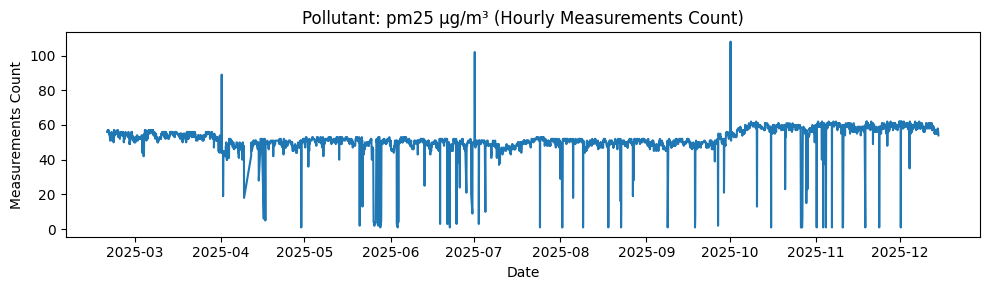

----------------------------------------------------------------
[PM10 ΜG/M³]: 361542 measurements
> Number of hours with low measurement counts (<40): 1.89% (132/6996)


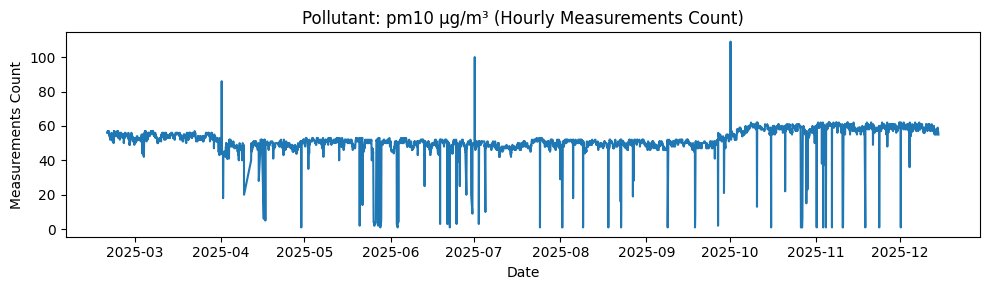

----------------------------------------------------------------
[O3 ΜG/M³]: 357520 measurements
> Number of hours with low measurement counts (<40): 2.23% (156/6996)


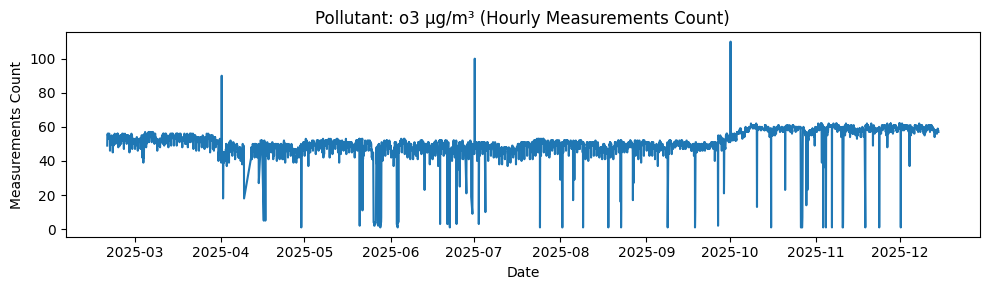

----------------------------------------------------------------
[NO2 PPB]: 359697 measurements
> Number of hours with low measurement counts (<40): 1.93% (135/6996)


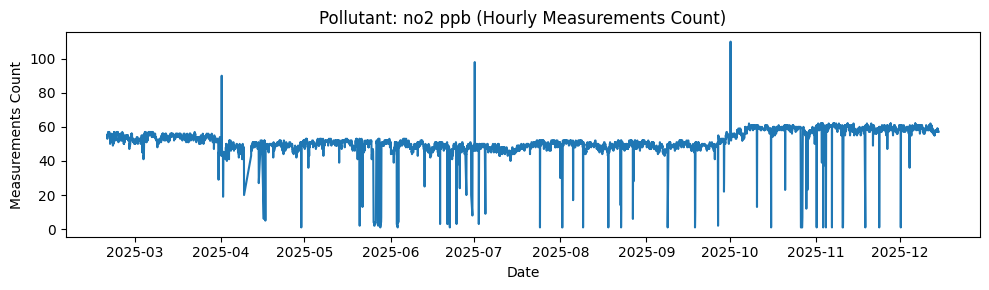

----------------------------------------------------------------
[NO PPB]: 356422 measurements
> Number of hours with low measurement counts (<40): 1.90% (133/6996)


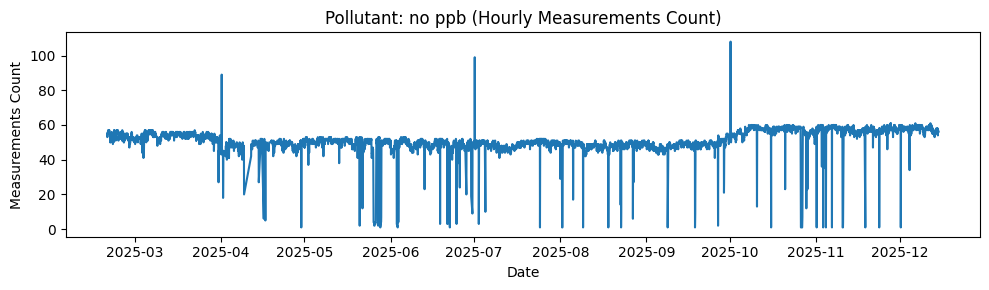

----------------------------------------------------------------
[CO PPB]: 355469 measurements
> Number of hours with low measurement counts (<40): 2.04% (143/6996)


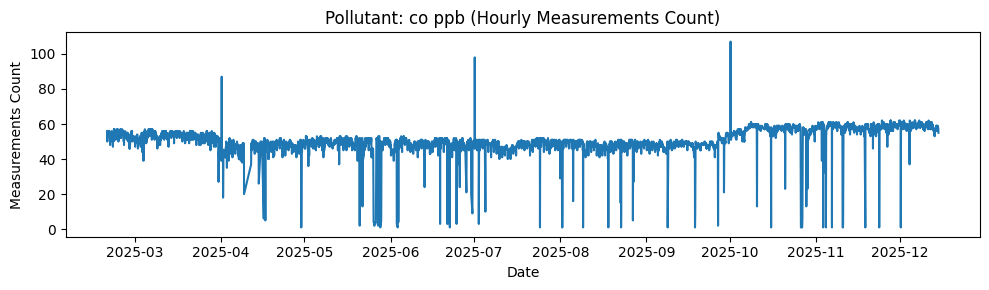

----------------------------------------------------------------
[NOX PPB]: 360911 measurements
> Number of hours with low measurement counts (<40): 1.92% (134/6996)


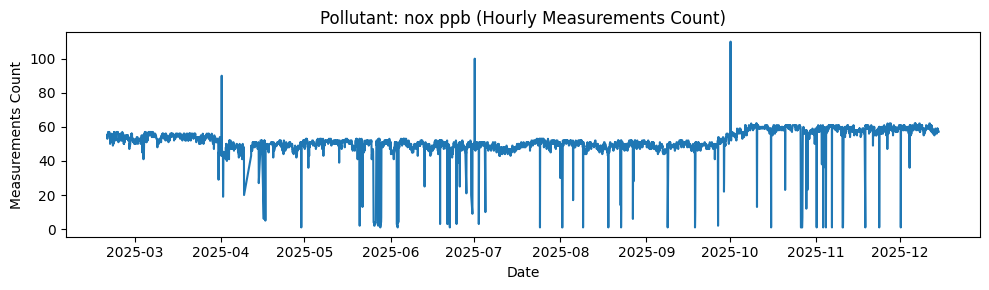

In [45]:
# TEST 2.2: for each pollutant, how many measurements (rows) do we have for the selected locations
# We already selected locations measuring all top pollutants with large coverage

# Just to have an idea of how many hours have low measurement counts
LOW_MEASUREMENT_COUNT_THRESHOLD = 40

title = f"NUMBER OF MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS ({selected_df['location_id'].nunique()})"
print(f"{'=' * len(title)}\n{title}\n")

unique_hours = selected_df["period.datetimeTo.local"].nunique()
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for i, pollutant in enumerate(top_pollutants_name):
    df_pollutant = selected_df[selected_df["name"] == pollutant]
    df_pollutant_by_datetime = df_pollutant.groupby("period.datetimeTo.local")["value"].count().reset_index()

    MASK_DATE_FILTER = pd.Series(True, index=df_pollutant_by_datetime.index)  # default: no filter
    # MASK_DATE_FILTER = (df_pollutant_by_datetime["period.datetimeTo.local"] >= "2025-03-01") & (df_pollutant_by_datetime["period.datetimeTo.local"] < "2025-05-01")

    print(f"{'-' * len(title)}\n[{pollutant.upper()}]: {df_pollutant.shape[0]} measurements")
    measurements_low_count = df_pollutant_by_datetime[df_pollutant_by_datetime["value"] < LOW_MEASUREMENT_COUNT_THRESHOLD].shape[0]
    print(f"> Number of hours with low measurement counts (<{LOW_MEASUREMENT_COUNT_THRESHOLD}): {measurements_low_count/unique_hours:.2%} ({measurements_low_count}/{unique_hours})")
    

    fig, ax =plt.subplots(1, 1, figsize=(10, 3))
    sns.lineplot(data=df_pollutant_by_datetime[MASK_DATE_FILTER], x="period.datetimeTo.local", y="value", ax=ax)
    ax.set_title(f"Pollutant: {pollutant} (Hourly Measurements Count)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Measurements Count")
    plt.tight_layout()
    plt.show()

# message = f"Locations coverage for all of the top pollutants: {full_locations_count/len(least_common_pollutant_locations):.2%} ({full_locations_count}/{len(least_common_pollutant_locations)} locations)"
# print(f"{message}\n{'_'*len(title)}")


#### Archives

In [168]:
# OVERLAP of each pollutant with each others

# TODO: Test ONLY the unique locations of the least common pollutant
# but test 

# Either jsut this one:
# least_common_pollutant_locations = filtered_df[filtered_df["name"] == least_common_pollutant]["location_id"].unique()
# # or the tested_pollutant_locations
# print(len(least_common_pollutant_locations))

name_max_length = max(len(name) for name in top_pollutants_name)
for pollutant in top_pollutants_name:
    tested_pollutant = pollutant
    tested_pollutant_locations = filtered_df[filtered_df["name"] == tested_pollutant]["location_id"].unique()
    other_pollutants = [p for p in top_pollutants_name if p != tested_pollutant]


    # print(f"Tested pollutant: {tested_pollutant}")
    print(f"[TESTING: {tested_pollutant.upper()} LOCATIONS ({len(tested_pollutant_locations)}) : Testing overlap of each pollutant with the tested pollutant:")
    print(f"  Other pollutants: {other_pollutants}")
    for other in other_pollutants:
        pollutant_locations = filtered_df[filtered_df["name"] == other]["location_id"].unique()

        common_locations = set(tested_pollutant_locations).intersection(set(pollutant_locations))
        print(f"  {other:<{name_max_length}} : {len(common_locations)/len(tested_pollutant_locations):>7.2%} ({len(common_locations)}/{len(tested_pollutant_locations)})")
    print()

[TESTING: PM25 ΜG/M³ LOCATIONS (72) : Testing overlap of each pollutant with the tested pollutant:
  Other pollutants: ['pm10 µg/m³', 'o3 µg/m³', 'no2 ppb', 'nox ppb', 'co ppb', 'no ppb']
  pm10 µg/m³ :  88.89% (64/72)
  o3 µg/m³   :  87.50% (63/72)
  no2 ppb    :  87.50% (63/72)
  nox ppb    :  86.11% (62/72)
  co ppb     :  86.11% (62/72)
  no ppb     :  84.72% (61/72)

[TESTING: PM10 ΜG/M³ LOCATIONS (64) : Testing overlap of each pollutant with the tested pollutant:
  Other pollutants: ['pm25 µg/m³', 'o3 µg/m³', 'no2 ppb', 'nox ppb', 'co ppb', 'no ppb']
  pm25 µg/m³ : 100.00% (64/64)
  o3 µg/m³   :  98.44% (63/64)
  no2 ppb    :  98.44% (63/64)
  nox ppb    :  96.88% (62/64)
  co ppb     :  96.88% (62/64)
  no ppb     :  95.31% (61/64)

[TESTING: O3 ΜG/M³ LOCATIONS (63) : Testing overlap of each pollutant with the tested pollutant:
  Other pollutants: ['pm25 µg/m³', 'pm10 µg/m³', 'no2 ppb', 'nox ppb', 'co ppb', 'no ppb']
  pm25 µg/m³ : 100.00% (63/63)
  pm10 µg/m³ : 100.00% (63/63)


In [81]:
# Test if one of the locations measuring um003 actually measures all metrics

location_to_test = unique_locations_tested[4]
df_location = filtered_df[filtered_df["location_id"] == location_to_test]
measured_parameters = df_location["name"].unique().tolist()
print(f"Location ID {location_to_test} measures the following parameters: {measured_parameters}")

Location ID 4663956 measures the following parameters: ['pm1 µg/m³', 'relativehumidity %', 'um003 particles/cm³', 'pm25 µg/m³', 'temperature c']


In [71]:
pollutants_dict = {}

# Get the unique locations list for each pollutant
for pollutant in top_pollutants_name:
    unique_locations = filtered_df[filtered_df["name"] == pollutant]["location_id"].unique()
    pollutants_dict[pollutant] = unique_locations
    # pollutants_dict[pollutant] = len(unique_locations)
    # print(f"{pollutant}: {len(unique_locations)} unique locations")

# print()
# print(pollutants_dict)

# Compare each pollutant's unique locations with pm25 unique locations to find overlaps
for pollutant in top_pollutants_name:
    if pollutant == "pm25 µg/m³":
        continue  # Skip comparison with itself
    unique_locations = pollutants_dict[pollutant]
    overlap = set(unique_locations_pm25).intersection(set(unique_locations))
    print(f"Overlap between pm25 µg/m³ and {pollutant}: {len(overlap)/len(unique_locations):.2%} ({len(overlap)}/{len(unique_locations)} locations)")

Overlap between pm25 µg/m³ and pm10 µg/m³: 100.00% (64/64 locations)
Overlap between pm25 µg/m³ and o3 µg/m³: 100.00% (63/63 locations)
Overlap between pm25 µg/m³ and no2 ppb: 100.00% (63/63 locations)
Overlap between pm25 µg/m³ and nox ppb: 100.00% (62/62 locations)
Overlap between pm25 µg/m³ and co ppb: 100.00% (62/62 locations)
Overlap between pm25 µg/m³ and no ppb: 100.00% (61/61 locations)
Overlap between pm25 µg/m³ and relativehumidity %: 100.00% (60/60 locations)
Overlap between pm25 µg/m³ and temperature c: 100.00% (60/60 locations)
Overlap between pm25 µg/m³ and so2 ppb: 100.00% (54/54 locations)
Overlap between pm25 µg/m³ and wind_speed m/s: 100.00% (54/54 locations)
Overlap between pm25 µg/m³ and wind_direction deg: 100.00% (54/54 locations)
Overlap between pm25 µg/m³ and pm1 µg/m³: 100.00% (6/6 locations)
Overlap between pm25 µg/m³ and um003 particles/cm³: 100.00% (6/6 locations)


In [37]:
result_df = (
    filtered_df.groupby("name")
    .agg(station_count=('sensor_id', 'count')) # Use a tuple (new_col_name, aggregation_func)
    .sort_values(by='station_count', ascending=False)
)
display(result_df)

,station_count
name,
pm25 µg/m³,44413
pm10 µg/m³,40412
no2 ppb,39906
o3 µg/m³,39613
nox ppb,38892
co ppb,38701
no ppb,38039
temperature c,36031
relativehumidity %,35987


In [19]:
filtered_df["name"].value_counts()

name
pm25 µg/m³             22802
pm10 µg/m³             20133
o3 µg/m³               19849
no2 ppb                19824
nox ppb                19602
co ppb                 19529
no ppb                 19172
temperature c          18983
relativehumidity %     18982
wind_speed m/s         17041
so2 ppb                16999
wind_direction deg     16910
pm1 µg/m³               2009
um003 particles/cm³     2009
Name: count, dtype: int64

In [17]:
groupby = filtered_df.groupby(["location_id", "name"]).size().sort_values(ascending=False)
pprint(groupby)

location_id  name               
6125489      temperature c          338
             relativehumidity %     338
6119272      pm1 µg/m³              338
             temperature c          338
2860223      pm1 µg/m³              338
             temperature c          338
             relativehumidity %     338
             pm25 µg/m³             338
             um003 particles/cm³    338
6125489      pm1 µg/m³              338
6119272      relativehumidity %     338
6125489      um003 particles/cm³    338
6119272      um003 particles/cm³    338
             pm25 µg/m³             338
6125489      pm25 µg/m³             338
4663956      um003 particles/cm³    337
6145551      pm1 µg/m³              337
             pm25 µg/m³             337
             relativehumidity %     337
             temperature c          337
4663956      pm1 µg/m³              337
6145551      um003 particles/cm³    337
4663956      temperature c          337
             pm25 µg/m³             337
       